In [2]:
from scipy.spatial.distance import mahalanobis
import numpy as np

In [3]:
a = np.array([2, 0, 0])
b = np.array([0, 1, 0])
iv = [[1, 0.5, 0.5], [0.5, 1, 0.5], [0.5, 0.5, 1]]

In [20]:
mahalanobis(a, b, iv)
# 1.7320508075688772

1.7320508075688772

In [18]:
def mahalanobis_distance(rhythm_data: np.ndarray, mean_vector: np.ndarray, inv_cov_matrix: np.ndarray) -> float:
    """
    Calculate the Mahalanobis distance for the given rhythm data.
    """
    return np.sqrt((rhythm_data - mean_vector).T @ inv_cov_matrix @ (rhythm_data - mean_vector))

In [19]:
mahalanobis_distance(a, b, iv)

1.7320508075688772

In [4]:
import mne
from mne.preprocessing import ICA
import numpy as np
import pywt
from typing import Tuple, List
from scipy.spatial.distance import mahalanobis

In [5]:
def read_eeg_data(edf_file_path: str, sfreq=256.) -> mne.io.Raw:
    """
    Reads EEG data from an EDF file, returns the data as a (channels, time samples) array.
    """
    raw = mne.io.read_raw_edf(edf_file_path, preload=True)
    
    montage = mne.channels.make_standard_montage('standard_1020')
    eeg_channels = ['Cz', 'Fp1', 'F7', 'P3', 'O1', 'Pz', 'O2', 'P4', 'F8', 'Fp2']

    raw.pick(eeg_channels)
    raw.set_montage(montage)
    
    raw.resample(sfreq)
    
    return raw

def preprocess_eeg(raw: mne.io.Raw) -> mne.io.Raw:
    """
    Apply Blind Source Separation (BSS) using Independent Component Analysis (ICA)
    to remove artifacts from the EEG data.
    
    Parameters:
    - sfreq: Sampling frequency of the EEG data.
    
    Returns:
    - Raw object with cleaned EEG data after ICA.
    """
    # Apply band-pass filter (1-50 Hz) to remove very low and high frequency noise
    raw.filter(1.0, 50.0, fir_design='firwin')
    
    raw.del_proj()
    
    # Fit ICA to the raw EEG data
    ica = ICA(n_components=10, random_state=97)
    ica.fit(raw)
    
    # Apply ICA to remove artifacts
    raw_cleaned = ica.apply(raw)
    
    return raw_cleaned

def extract_rhythms(raw_cleaned_data: mne.io.Raw, sfreq: float, 
                    alpha_band=(8, 12), 
                    theta_band=(4, 8)):
    """
    Extract alpha (8-12 Hz) and theta (4-8 Hz) rhythms.
    
    Parameters:
    - raw_cleaned_data: Cleaned EEG data in MNE Raw format.
    - sfreq: Sampling frequency.
    - alpha_band: Tuple representing the frequency range for alpha rhythm.
    - theta_band: Tuple representing the frequency range for theta rhythm.
    
    Returns:
    - Tuple containing two NumPy arrays: (alpha_rhythms, theta_rhythms).
    """
    eeg_data: np.ndarray = raw_cleaned_data.get_data()  # (channels x time samples)
    coeffs_alpha: List[np.ndarray] = []
    coeffs_theta: List[np.ndarray] = []
    
    for channel_data in eeg_data:
        # Perform continuous wavelet transform (CWT) for each channel
        coeffs, freqs = pywt.cwt(channel_data, scales=np.arange(1, 128), wavelet='morl', sampling_period=1/sfreq)
        
        # Extract alpha and theta power using the specified frequency bands
        alpha_power = np.mean([coeffs[i] for i, f in enumerate(freqs) if alpha_band[0] <= f <= alpha_band[1]], axis=0)
        theta_power = np.mean([coeffs[i] for i, f in enumerate(freqs) if theta_band[0] <= f <= theta_band[1]], axis=0)
        
        coeffs_alpha.append(alpha_power)
        coeffs_theta.append(theta_power)
    
    return np.array(coeffs_alpha), np.array(coeffs_theta)

def mahalanobis_distance(rhythm_data: np.ndarray, mean_vector: np.ndarray, cov_matrix: np.ndarray) -> float:
    """
    Calculate the Mahalanobis distance for the given rhythm data.
    """
    # return mahalanobis(rhythm_data, mean_vector, np.linalg.inv(cov_matrix))
    return np.sqrt((rhythm_data - mean_vector).T @ np.linalg.inv(cov_matrix) @ (rhythm_data - mean_vector))

def combined_deviation(alpha_data: np.ndarray, theta_data: np.ndarray, 
                       mean_alpha: np.ndarray, cov_alpha: np.ndarray, 
                       mean_theta: np.ndarray, cov_theta: np.ndarray, 
                       sigma: float = 0.5) -> float:
    """
    Calculate the combined deviation (DC) based on weighted Mahalanobis distances of alpha and theta rhythms.
    
    Returns:
    - Combined deviation
    """
    D_alpha: float = mahalanobis_distance(alpha_data, mean_alpha, cov_alpha)
    D_theta: float = mahalanobis_distance(theta_data, mean_theta, cov_theta)
    
    # Weighted sum of distances
    DC: float = sigma * D_alpha + (1 - sigma) * D_theta
    return DC

def detect_fatigue(DC: float, threshold: float=6.0) -> bool:
    """
    TODO: Calculate threshold dynamically
    DC > threshold
    """
    return DC > threshold

In [28]:
c =  ['Cz',
    'Fp1',
    'F7',
    'F3',
    'CP5',
    'CP1',
    'P1',
    'P3',
    'P5',
    'P7',
    'PO9',
    'PO7',
    'PO3',
    'O1',
    'O9',
    'Pz',
    'POz',
    'Oz',
    'O10',
    'O2',
    'PO4',
    'PO8',
    'PO10',
    'P8',
    'P6',
    'P4',
    'P2',
    'CP2',
    'CP6',
    'F4',
    'F8',
    'Fp2']

d = ['Fp1', 'Fp2', 'F7', 'F8', 'Fz', 'Cz', 'C3', 'C4', 'Pz', 'P3', 'P4', 'O1', 'O2', 'T3', 'T4', 'T5', 'T6']

list(filter(lambda x: x in d, c))

['Cz', 'Fp1', 'F7', 'P3', 'O1', 'Pz', 'O2', 'P4', 'F8', 'Fp2']

In [6]:
r = read_eeg_data('./block1.edf', 256.)

Extracting EDF parameters from c:\Users\andre\projects\baseline\block1.edf...
EDF file detected


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 64511  =      0.000 ...   251.996 secs...
Sampling frequency of the instance is already 256.0, returning unmodified.


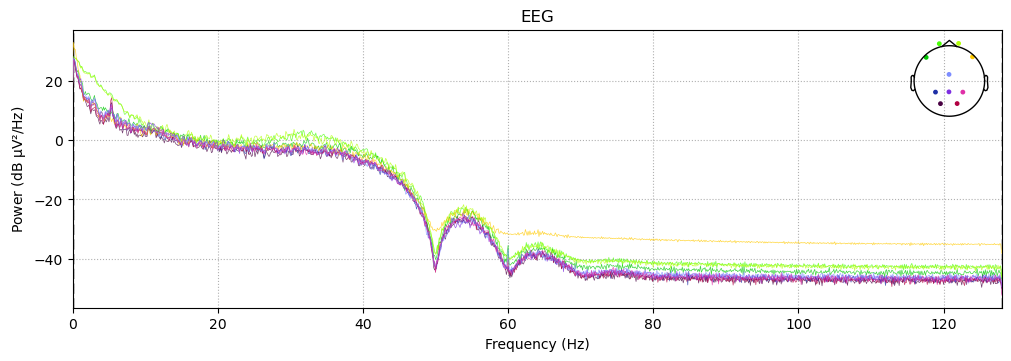

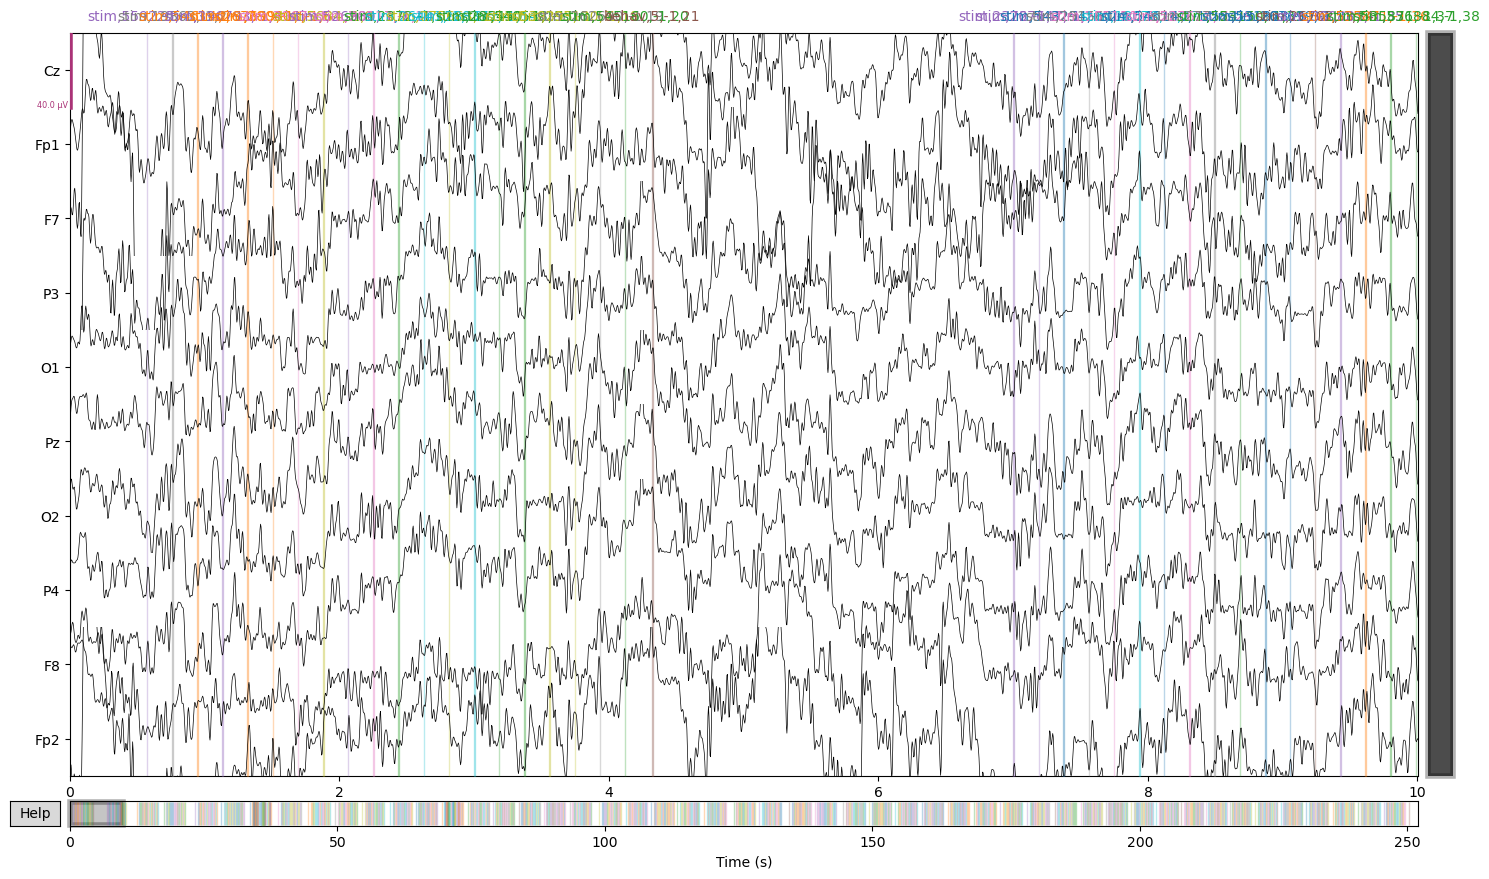

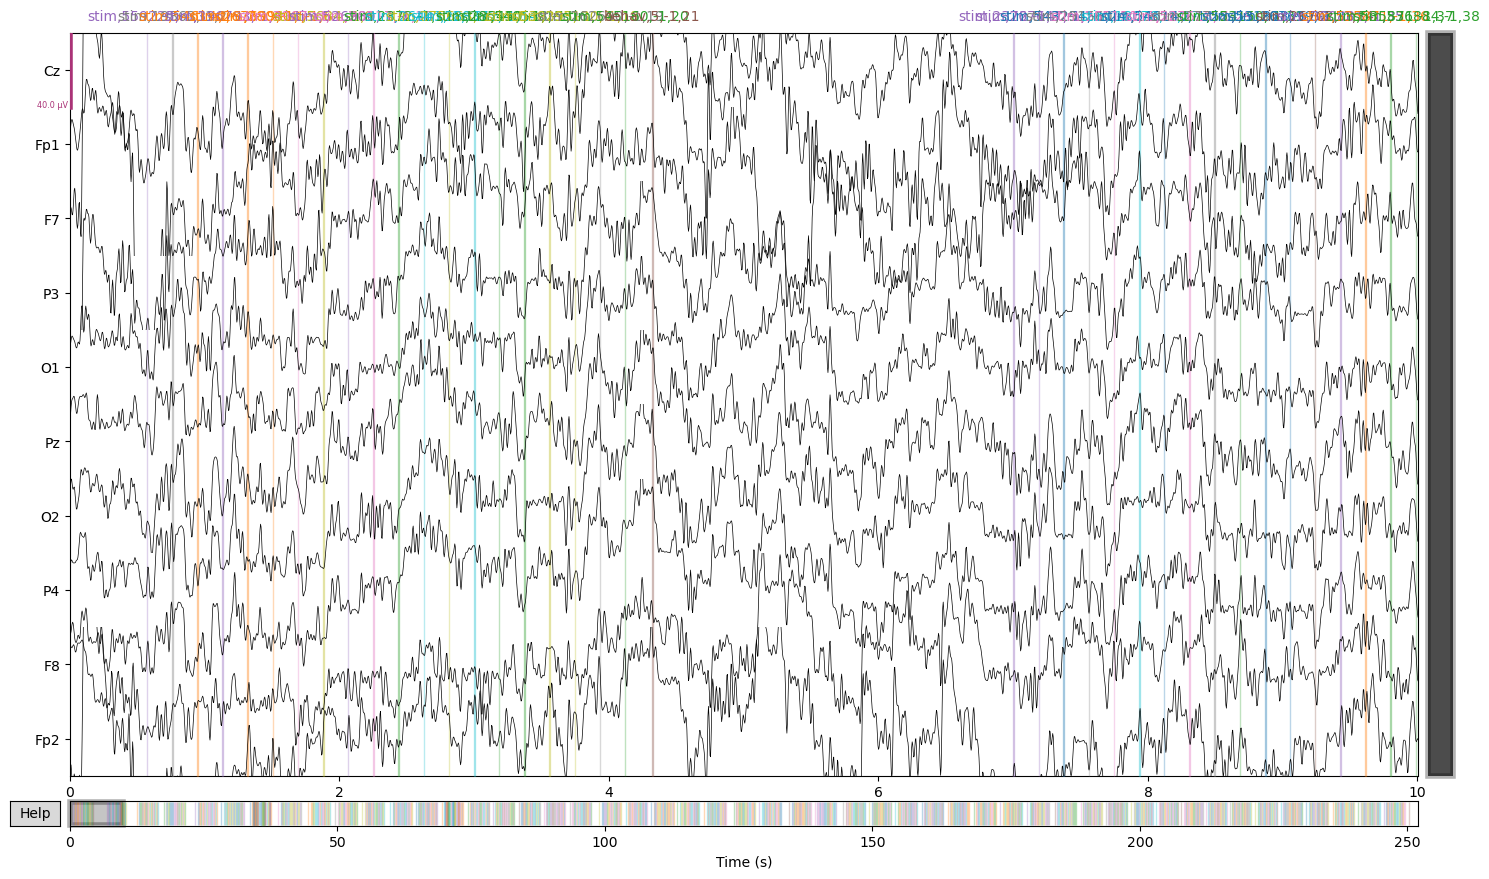

In [10]:
r.plot()

In [62]:
cr = preprocess_eeg(r)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 10 PCA components


In [66]:
cr.get_data().shape

(10, 64512)

In [65]:
# Extract rhythms
alpha_rhythms, theta_rhythms = extract_rhythms(cr, 256.)

In [81]:
# Compute Mahalanobis distance and combined deviation (DC)
mean_alpha = np.mean(alpha_rhythms, axis=1)
cov_alpha = np.cov(alpha_rhythms)
mean_theta = np.mean(theta_rhythms, axis=1)
cov_theta = np.cov(theta_rhythms)


In [88]:
alpha_rhythms[:, 0].shape
alpha_rhythms.shape

(10, 64512)

In [86]:
DC: float = combined_deviation(alpha_rhythms[:, 0], theta_rhythms[:, 0], mean_alpha, cov_alpha, mean_theta, cov_theta)

In [87]:
DC

2.5637820019040825